在此练习中，我们将使用logistic回归和神经网络来识别手写数字（0到9）。

# 多类分类

我们将扩展我们在练习2中写的logistic回归的实现，并将其应用于一对多的分类（不止两个类别）。

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

## Dataset
首先，加载数据集。这里的数据为MATLAB的格式，所以要使用SciPy.io的loadmat函数。

In [4]:
def load_data(path):
    data = loadmat(path)
    X = data['X']
    y = data['y']
    return X,y

In [6]:
X, y = load_data('ex3data1.mat')
print(np.unique(y))  # 看下有几类标签)
X.shape, y.shape

[ 1  2  3  4  5  6  7  8  9 10]


((5000, 400), (5000, 1))

其中有5000个训练样本，每个样本是20\*20像素的数字的灰度图像。每个像素代表一个浮点数，表示该位置的灰度强度。20×20的像素网格被展开成一个400维的向量。在我们的数据矩阵X中，每一个样本都变成了一行，这给了我们一个5000×400矩阵X，每一行都是一个手写数字图像的训练样本。
![image.png](../img/3_1.png)

第一个任务是将我们的逻辑回归实现修改为完全向量化（即没有“for”循环）。这是因为向量化代码除了简洁外，还能够利用线性代数优化，并且通常比迭代代码快得多。但是，如果从练习2中看到我们的代价函数已经完全向量化实现了，所以我们可以在这里重复使用相同的实现。

## 1.2 Visualizing the data

In [7]:
def plot_an_image(X):
    """
    随机打印一个数字
    """
    pick_one = np.random.randint(0, 5000)
    image = X[pick_one, :]
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.matshow(image.reshape((20, 20)), cmap='gray_r')
    plt.xticks([])  # 去除刻度，美观
    plt.yticks([])
    plt.show()
    print('this should be {}'.format(y[pick_one]))

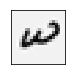

this should be [3]


In [18]:
plot_an_image(X)

In [22]:
def plot_100_image(X):
    """ 
    随机画100个数字
    """
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 随机选100个样本
    sample_images = X[sample_idx, :]  # (100,400)
    
    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

    for row in range(10):
        for column in range(10):
            ax_array[row, column].matshow(sample_images[10 * row + column].reshape((20, 20)),
                                   cmap='gray_r')
    plt.xticks([])
    plt.yticks([])        
    plt.show()

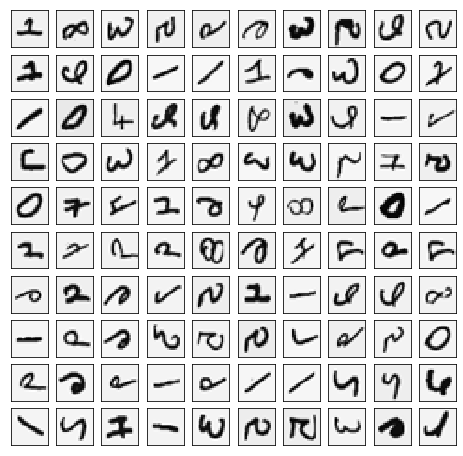

In [23]:
plot_100_image(X)

## 1.3 Vectorizing Logistic Regression

我们将使用多个one-vs-all(一对多)logistic回归模型来构建一个多类分类器。由于有10个类，需要训练10个独立的分类器。为了提高训练效率，重要的是**向量化**。在本节中，我们将实现一个不使用任何for循环的向量化的logistic回归版本。

首先准备下数据。

### 1.3.1 Vectorizing the cost function

首先写出向量化的代价函数。回想正则化的logistic回归的代价函数是：
$$ J\left( \theta  \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda}{2m}\sum^n_{j=1}\theta^2_j $$

首先我们对每个样本 $i$ 要计算$h_{\theta}(x^{(i)})$，$h_{\theta}(x^{(i)})=g(\theta^Tx^{(i)})$，$g(z)=\frac{1}{1+e^{-z}}$ sigmoid函数。

事实上我们可以对所有的样本用矩阵乘法来快速的计算。让我们如下来定义 $X$ 和 $\theta$ ：
![image.png](../img/3_2.png)

然后通过计算矩阵积 $X\theta$ ，我们可以得到：
![image.png](../img/3_3.png)

在最后一个等式中，我们用到了一个定理，如果 $a$ 和 $b$ 都是向量，那么 $a^Tb=b^Ta$，这样我们就可以用一行代码计算出所有的样本。

In [24]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [51]:
def regularized_cost(theta, X, y, l):
    """
    don't penalize theta_0
    args:
        X: feature matrix, (m, n+1) # 插入了x0=1
        y: target vector, (m, )
        l: lambda constant for regularization
    """
    thetaReg = theta[1:]
    first = (-y*np.log(sigmoid(X@theta))) + (y-1)*np.log(1-sigmoid(X@theta))
    reg = (thetaReg@thetaReg)*l / (2*len(X))
    return np.mean(first) + reg

### 1.3.2 Vectorizing the gradient
回顾正则化logistic回归代价函数的梯度下降法如下表示，因为不惩罚theta_0，所以分为两种情况：
\begin{align}
  & Repeat\text{ }until\text{ }convergence\text{ }\!\!\{\!\!\text{ } \\ 
 & \text{     }{{\theta }_{0}}:={{\theta }_{0}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{_{0}}^{(i)}} \\ 
 & \text{     }{{\theta }_{j}}:={{\theta }_{j}}-a\frac{1}{m}\sum\limits_{i=1}^{m}{[{{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x_{j}^{(i)}}+\frac{\lambda }{m}{{\theta }_{j}} \\ 
 & \text{          }\!\!\}\!\!\text{ } \\ 
 & Repeat \\ 
\end{align}

所以其中的梯度表示如下：

In [50]:
def regularized_gradient(theta, X, y, l):
    """
    don't penalize theta_0
    args:
        l: lambda constant
    return:
        a vector of gradient
    """
    thetaReg = theta[1:]
    first = (1 / len(X)) * X.T @ (sigmoid(X @ theta) - y)
    # 这里人为插入一维0，使得对theta_0不惩罚，方便计算
    reg = np.concatenate([np.array([0]), (l / len(X)) * thetaReg])
    return first + reg

## 1.4 One-vs-all Classification

这部分我们将实现一对多分类通过训练多个正则化logistic回归分类器，每个对应数据集中K类中的一个。

对于这个任务，我们有10个可能的类，并且由于logistic回归只能一次在2个类之间进行分类，每个分类器在“类别 i”和“不是 i”之间决定。 我们将把分类器训练包含在一个函数中，该函数计算10个分类器中的每个分类器的最终权重，并将权重返回shape为(k, (n+1))数组，其中 n 是参数数量。

In [52]:
from scipy.optimize import minimize

def one_vs_all(X, y, l, K):
    """generalized logistic regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization
        K: numbel of labels
    return: trained parameters
    """
    all_theta = np.zeros((K, X.shape[1]))  # (10, 401)
    
    for i in range(1, K+1):
        theta = np.zeros(X.shape[1])
        y_i = np.array([1 if label == i else 0 for label in y])
#         y_i = np.reshape(y_i, (-1, 1))  # 重新转化为列向量
    
        ret = minimize(fun=regularized_cost, x0=theta, args=(X, y_i, l), method='TNC',
                        jac=regularized_gradient, options={'disp': True})
        all_theta[i-1,:] = ret.x
                         
    return all_theta

这里需要注意的几点：首先，我们为X添加了一列常数项 1 ，以计算截距项（常数项）。 其次，我们将y从类标签转换为每个分类器的二进制值（要么是类i，要么不是类i）。 最后，我们使用SciPy的较新优化API来最小化每个分类器的代价函数。 如果指定的话，API将采用目标函数，初始参数集，优化方法和jacobian（渐变）函数。 然后将优化程序找到的参数分配给参数数组。

实现向量化代码的一个更具挑战性的部分是正确地写入所有的矩阵，保证维度正确。

In [53]:
def predict_all(X, all_theta):
    # compute the class probability for each class on each training instance   
    h = sigmoid(X @ all_theta.T)  # 注意的这里的all_theta需要转置
    # create array of the index with the maximum probability
    # Returns the indices of the maximum values along an axis.
    h_argmax = np.argmax(h, axis=1)
    # because our array was zero-indexed we need to add one for the true label prediction
    h_argmax = h_argmax + 1
    
    return h_argmax

这里的`h`共5000行，10列，每行代表一个样本，每列是预测对应数字的概率。我们取概率最大对应的index加1就是我们分类器最终预测出来的类别。返回的`h_argmax`是一个array，包含5000个样本对应的预测值。

In [54]:
raw_X, raw_y = load_data('ex3data1.mat')
X = np.insert(raw_X, 0, 0, axis=1) # (5000, 401)
y = raw_y.flatten()  # 这里消除了一个维度，方便后面的计算 or .reshape(-1) （5000，）

all_theta = one_vs_all(X, y, 1, 10)
all_theta  # 每一行是一个分类器的一组参数

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.31141206e-03, -1.16971030e-09,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         3.28206468e-03, -3.75794187e-04,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.63821882e-05, -3.16577807e-07,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.37694354e-03,  1.43370120e-04,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.83089562e-03,  2.13921244e-04,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.36585836e-04,  7.89392474e-06,  0.00000000e+00]])

In [55]:
y_pred = predict_all(X, all_theta)
accuracy = np.mean(y_pred == y)
print ('accuracy = {0}%'.format(accuracy * 100))

accuracy = 94.12%


In [63]:
def predict(x, theta):
    prob = sigmoid(x @ theta)
    return (prob >= 0.5).astype(int)

y_pred = predict(X, all_theta[1])
print('Accuracy={}'.format(np.mean((y==1) == y_pred)))

Accuracy=0.8102


**Tips: python中 true就是1，1就是true，false就是0，0就是false**

In [64]:
y_pred == y

array([False, False, False, ..., False, False, False])

# 2 Neural Networks
上面使用了多类logistic回归，然而logistic回归不能形成更复杂的假设，因为它只是一个线性分类器。

接下来我们用神经网络来尝试下，神经网络可以实现非常复杂的非线性的模型。我们将利用已经训练好了的权重进行预测。
![image.png](../img/3_4.png)

In [65]:
def load_weight(path):
    data = loadmat(path)
    return data['Theta1'], data['Theta2']

In [67]:
theta1, theta2 = load_weight('ex3weights.mat')
theta1.shape, theta2.shape

((25, 401), (10, 26))

 因此在数据加载函数中，原始数据做了转置，然而，转置的数据与给定的参数不兼容，因为这些参数是由原始数据训练的。 所以为了应用给定的参数，我需要使用原始数据（不转置）

In [68]:
X, y = load_data('ex3data1.mat')
y = y.flatten()
X = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)  # intercept
X.shape, y.shape

((5000, 401), (5000,))

In [69]:
a1 = X
z2 = a1 @ theta1.T
z2.shape

(5000, 25)

In [70]:
z2 = np.insert(z2, 0, 1, axis=1)

In [71]:
a2 = sigmoid(z2)
a2.shape

(5000, 26)

In [72]:
z3 = a2 @ theta2.T
z3.shape

(5000, 10)

In [73]:
a3 = sigmoid(z3)
a3.shape

(5000, 10)

In [74]:
y_pred = np.argmax(a3, axis=1) + 1 
accuracy = np.mean(y_pred == y)
print ('accuracy = {0}%'.format(accuracy * 100))

accuracy = 97.52%


虽然人工神经网络是非常强大的模型，但训练数据的准确性并不能完美预测实际数据，在这里很容易过拟合。